In [1]:
import time
import warnings

from sklearn import cluster, datasets, decomposition, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

# Basics / Mathematics

### Example 1
This is a basic example that can be used to introduce PCA or any clustering algorithm in particular (the default is set to KMeans right now)

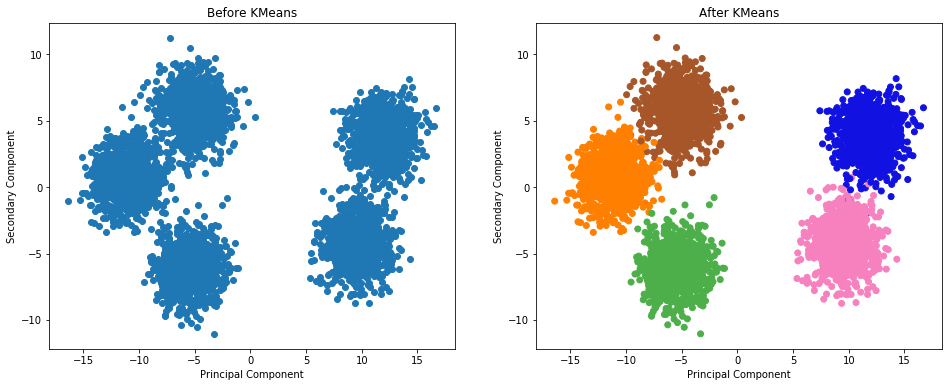

In [4]:
n_clusters = 5 # The number of clusters
n_points = 1000 # The number of points in each cluster
n_dimensions = 4 # The number of dimensions
standard_dev = 1.5 # The standard deviation of each cluster

#########################################################################################################################################################################

data, realClusters = datasets.make_blobs(n_samples=n_clusters*n_points, centers=n_clusters, n_features=n_dimensions, cluster_std=standard_dev, random_state=111)

# Cluster the data
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=111)
kmeansClusters = kmeans.fit_predict(data)

# PCA data into 2D
pca = decomposition.PCA(n_components=2)
dataPCA = pca.fit_transform(data)

# Plot
fig = plt.figure(figsize=(16,6))

colors = np.array(list(islice(cycle(['#1111e1', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']), int(max(kmeansClusters) + 1))))
colors = np.append(colors, ["#000000"])

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Secondary Component')
ax1.scatter(dataPCA[:,0], dataPCA[:,1])
plt.title('Before KMeans')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Secondary Component')
ax2.scatter(dataPCA[:,0], dataPCA[:,1], c=colors[kmeansClusters])
plt.title('After KMeans')

plt.show()

### Example 2
This example serves as a comparison of how different clustering algorithms perform on toy data sets

Inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

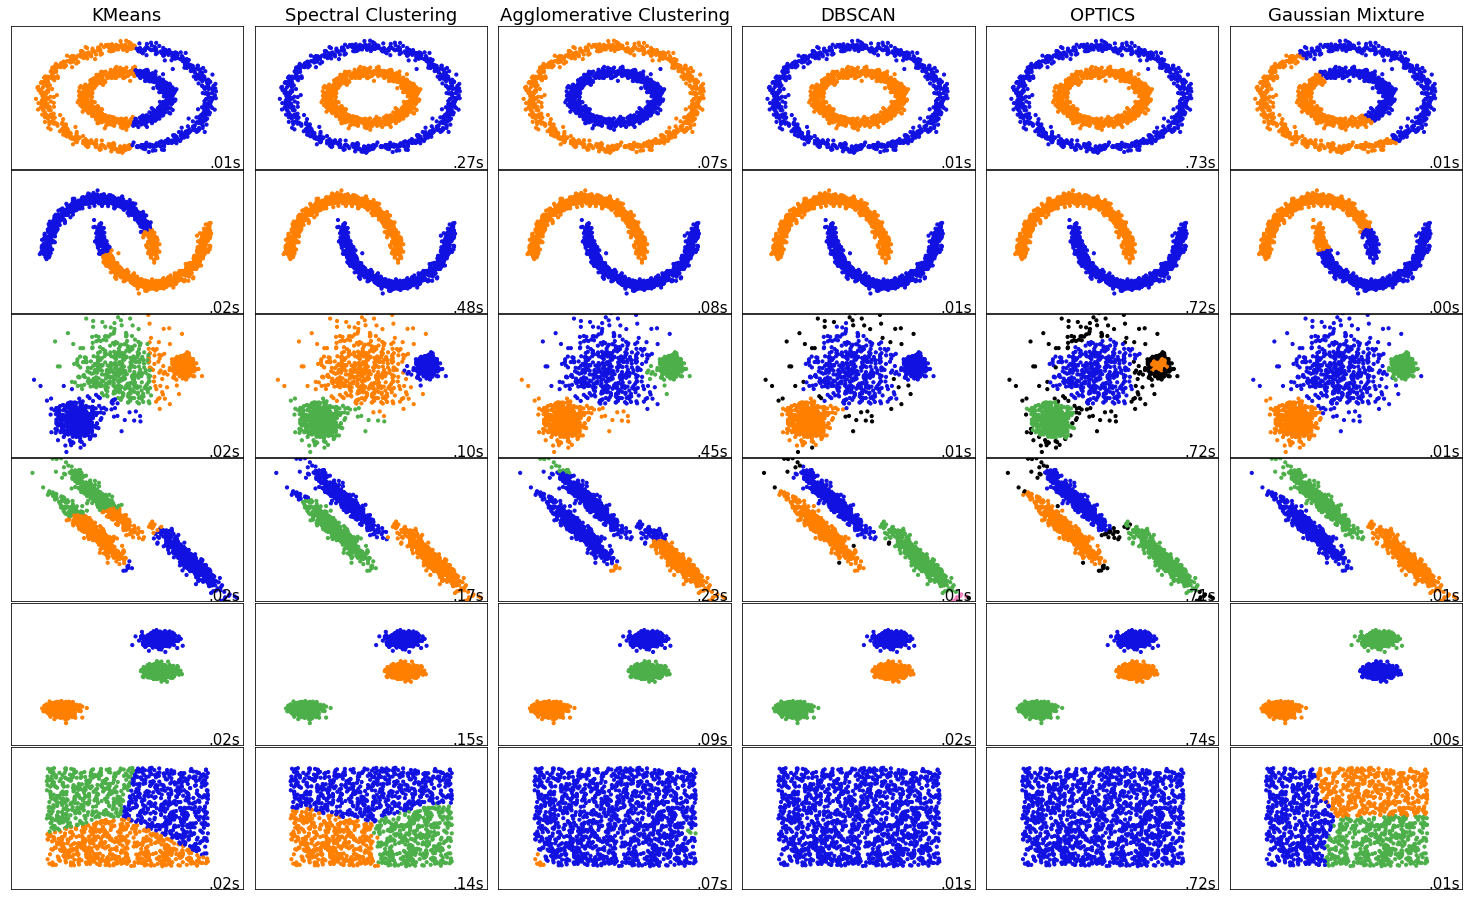

In [11]:
#######################################################################################################################################################
np.random.seed(0)

# Generate datasets
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# Set up cluster parameters
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference': -200, 'n_neighbors': 10, 
                'n_clusters': 3, 'min_samples': 20, 'xi': 0.05, 'min_cluster_size': 0.1}

data = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(data):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('KMeans', two_means),
        ('Spectral Clustering', spectral),
        ('Agglomerative Clustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Gaussian Mixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(data), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#1111e1', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Chemistry Example

### Aerosol Classification from Spectral UV Measurements Using Machine Learning Clustering

Inspired by https://www.mdpi.com/2072-4292/12/6/965

# Fun Example

### Using Country-Level Variables to Classify Countries According to the Number of Confirmed COVID-19 Cases

Inspired by https://wellcomeopenresearch.org/articles/5-56